In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedKFold
from sklearn import grid_search
from sklearn import linear_model, metrics, preprocessing
from sklearn.feature_selection import RFE,SelectPercentile,f_classif,chi2
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
import xgboost as xgb

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### Load data

In [13]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

skf_cv = StratifiedKFold(df_train['TARGET'], n_folds=6, shuffle=True, random_state=None) # split target equally
def score_model(model,X,t):
    #return cross_val_score(model, X, t, cv=6, scoring="roc_auc",n_jobs=3)
    return cross_val_score(model, X, t, cv=skf_cv, scoring="roc_auc",n_jobs=3)

### Remove constant columns

In [14]:
remove = []
for col in df_train.columns:
    if df_train[col].std() == 0:
        remove.append(col)

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

### Remove duplicated columns

In [15]:
remove = []
c = df_train.columns
for i in range(len(c)-1):
    v = df_train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_train[c[j]].values):
            remove.append(c[j])

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

### Other cleaning

In [16]:
# Replace -999999 in var3 column with most common value 2 
df_train = df_train.replace(-999999,2)
df_test = df_test.replace(-999999,2)

### Feature selection

In [17]:
Xdf_tr = df_train.drop('TARGET', 1)
tdf_tr = df_train.TARGET

from sklearn.preprocessing import Binarizer, scale

p = 50 # percentage of selected features

X_bin = Binarizer().fit_transform(scale(Xdf_tr))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, tdf_tr)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(Xdf_tr, tdf_tr)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if chi2_selected[i]]

f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if f_classif_selected[i]]


selected = chi2_selected | f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(Xdf_tr.columns, selected) if s]
Xdf=df_train[features]

# print('List of features:{}'.format(features))


Chi2 & F_classif selected 173 features


### Extract training data

In [18]:
#from sklearn import preprocessing
#X_tr = preprocessing.scale(Xdf.as_matrix())

X_tr = Xdf.as_matrix()
t_tr = df_train['TARGET'].as_matrix()

N_tr=np.shape(X_tr)[0]
D=np.shape(X_tr)[1]

In [19]:
n_estimators = 60
learning_rate = 0.4
dt = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt.fit(X_tr, t_tr)

ada = AdaBoostClassifier(
            base_estimator=dt,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            algorithm="SAMME.R")
ada.fit(X_tr, t_tr)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.4, n_estimators=60, random_state=None)

In [23]:
cv_scores={}
cv_scores['Decision tree']=score_model(dt, X_tr,t_tr)
cv_scores['Adaboost']=score_model(ada, X_tr,t_tr)
print cv_scores

{'Adaboost': array([ 0.8337877 ,  0.83283597,  0.84004872,  0.81394414,  0.82969925,
        0.84774895]), 'Decision tree': array([ 0.68161588,  0.68779742,  0.68113473,  0.66150877,  0.6810179 ,
        0.68897265])}


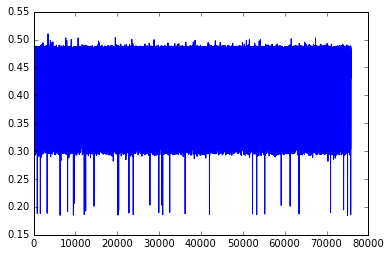

In [20]:
X_test = df_test[features].as_matrix()
t_pred=ada.predict_proba(X_test)[:,1]
plt.plot(t_pred)

In [21]:
print t_pred

[ 0.47285907  0.4734504   0.44175377 ...,  0.43548668  0.47011252
  0.43258146]


In [22]:
id_test = df_test['ID']
submission = pd.DataFrame({"ID":id_test, "TARGET": t_pred})
submission.to_csv("./data/submission_ada_estimators_60_learningrate_04.csv", index=False)